<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL/blob/master/Stock_NeurIPS2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version** 



# Content

* [1. Task Description](#0)
* [2. Install Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. A List of Python Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download and Preprocess Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5. Build Market Environment in OpenAI Gym-style](#4)  
    * [5.1. Data Split](#4.1)  
    * [5.3. Environment for Training](#4.2)    
* [6. Train DRL Agents](#5)
* [7. Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
  

<a id='0'></a>
# Part 1. Task Discription

We train a DRL agent for stock trading. This task is modeled as a Markov Decision Process (MDP), and the objective function is maximizing (expected) cumulative return.

We specify the state-action-reward as follows:

* **State s**: The state space represents an agent's perception of the market environment. Just like a human trader analyzing various information, here our agent passively observes many features and learns by interacting with the market environment (usually by replaying historical data).

* **Action a**: The action space includes allowed actions that an agent can take at each state. For example, a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying. When an action operates multiple shares, a ∈{−k, ..., −1, 0, 1, ..., k}, e.g.. "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* **Reward function r(s, a, s′)**: Reward is an incentive for an agent to learn a better policy. For example, it can be the change of the portfolio value when taking a at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively


**Market environment**: 30 consituent stocks of Dow Jones Industrial Average (DJIA) index. Accessed at the starting date of the testing period.


The data for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Install Python Packages

<a id='1.1'></a>
## 2.1. Install packages


NameError: name 'stable_baselines3' is not defined

In [55]:
pip install sklearn -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2935 sha256=074a7861b17cd803b1477bf944737259451de058e2e3901a4edfe399848afa36
  Stored in directory: /Users/hanlinwang/Library/Caches/pip/wheels/0f/a7/92/2c7596590535721a0de7f07ba08f62e7bfcffcec1eefe4445a
Successfully built sklearn
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install git+https://github.com/quantopian/pyfolio

In [ ]:
## install finrl library
!pip install wrds -i https://pypi.tuna.tsinghua.edu.cn/simple
!pip install swig -i https://pypi.tuna.tsinghua.edu.cn/simple
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git 


<a id='1.2'></a>
## 2.2. A list of Python packages 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading_add import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools

<a id='1.4'></a>
## 2.4. Create Folders

In [3]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])



<a id='2'></a>
# Part 3. Download Data
Yahoo Finance provides stock data, financial news, financial reports, etc. Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** in FinRL-Meta to fetch data via Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).



-----
class YahooDownloader:
    Retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()


In [6]:
# from config.py, TRAIN_START_DATE is a string
TRAIN_START_DATE
# from config.py, TRAIN_END_DATE is a string
TRAIN_END_DATE

'2021-02-28'

In [4]:
TRAIN_START_DATE = '2012-10-10'
TRAIN_END_DATE = '2021-02-28'
TRADE_START_DATE = '2021-03-01'
TRADE_END_DATE = '2022-02-28'


In [5]:
import tushare as ts
ts.set_token('6314756019e50a6672690e5a78b2dbf7cfcd27c6f6a6b48a8cf76dae')
pro = ts.pro_api()

In [6]:
#选择上证50指数的成分股
df_index = pro.index_weight(index_code='000016.sh', start_date='20121010', end_date='20220228')
# df_index.to_csv('SSE_50_index_weight.csv',index=0)

In [10]:
#选择某个时间点的上证50指数成分股作为参考跟踪股票池
select_date = '20200228' #自定义的时间点为每个月的月末
df_select = df_index[df_index['trade_date']==select_date]
sort_SSEindex = df_select['con_code'].unique()
print(sort_SSEindex,len(sort_SSEindex))

['603993.SH' '603259.SH' '601989.SH' '601988.SH' '601939.SH' '601888.SH'
 '601857.SH' '601818.SH' '601766.SH' '601688.SH' '601668.SH' '601628.SH'
 '601601.SH' '601398.SH' '601390.SH' '601336.SH' '601328.SH' '601319.SH'
 '601318.SH' '601288.SH' '601236.SH' '601211.SH' '601186.SH' '601166.SH'
 '601138.SH' '601111.SH' '601088.SH' '601066.SH' '601012.SH' '600887.SH'
 '600837.SH' '600703.SH' '600690.SH' '600585.SH' '600547.SH' '600519.SH'
 '600340.SH' '600309.SH' '600276.SH' '600196.SH' '600104.SH' '600050.SH'
 '600048.SH' '600036.SH' '600031.SH' '600030.SH' '600028.SH' '600016.SH'
 '600009.SH' '600000.SH'] 50


In [11]:
#随机选择成分股中的k只股票
import random 
k = 20
selected_tics = random.sample(list(sort_SSEindex),k)
print(selected_tics)

['600887.SH', '600547.SH', '600340.SH', '600519.SH', '601211.SH', '601288.SH', '601601.SH', '600703.SH', '601088.SH', '601138.SH', '601888.SH', '600048.SH', '600585.SH', '601318.SH', '601989.SH', '601012.SH', '601688.SH', '603993.SH', '600000.SH', '600030.SH']


In [ ]:
#如果选择从config中配置可以用这段代码快速更改后缀
# new = []
# for c in config_tickers.SSE_50_TICKER:
#     c = c.replace('XSHG','SH')
#     new.append(c)
# print(new,len(new))

In [13]:
#Download随机选择的k只股票数据
df_ts =pd.DataFrame()
for c in selected_tics:
    temp=pro.daily(ts_code=c,start_date='20121010',end_date='20220228')
    df_ts=pd.concat([df_ts,temp])
print(df_ts)

        ts_code trade_date   open   high    low  close  pre_close  change  \
0     600887.SH   20220228  39.03  39.54  39.01  39.52      39.50    0.02   
1     600887.SH   20220225  39.66  40.12  39.30  39.50      39.52   -0.02   
2     600887.SH   20220224  40.13  40.13  38.94  39.52      40.24   -0.72   
3     600887.SH   20220223  41.00  41.20  40.05  40.24      40.49   -0.25   
4     600887.SH   20220222  40.73  40.78  39.90  40.49      41.01   -0.52   
...         ...        ...    ...    ...    ...    ...        ...     ...   
2260  600030.SH   20121016  11.56  11.79  11.56  11.65      11.60    0.05   
2261  600030.SH   20121015  11.58  11.71  11.44  11.60      11.54    0.06   
2262  600030.SH   20121012  11.68  11.79  11.32  11.54      11.58   -0.04   
2263  600030.SH   20121011  11.75  11.83  11.50  11.58      11.80   -0.22   
2264  600030.SH   20121010  11.81  11.85  11.73  11.80      11.86   -0.06   

      pct_chg        vol       amount  
0      0.0506  247484.40   971809.1

In [18]:
df_ts.to_csv('20_test1',index=None)

In [19]:
max_len = max(df_ts['ts_code'].value_counts())

In [ ]:
df_ts = pd.read_csv('20_test1')

In [ ]:
# #检验50只股票的信息缺省的时间点和个数
# dimatch_num = 0
# dimatch_date =[]
# for c in df_ts1['trade_date'].unique():
#     temp = df_ts1[df_ts1['trade_date'] == c]
#     if len(temp) != 50:
#         dimatch_num +=1
#         dimatch_date.append(c)
# print(dimatch_num,dimatch_date)

In [ ]:
# #获取SSE的交易日历
# import exchange_calendars as tc
# def get_trading_days(exchange: str, start_date: str, end_date: str):
#     days = pro.trade_cal(exchange=exchange, start_date=start_date, end_date=end_date)
#     days = days[days['is_open'] == 1]
#     full_date_range = pd.DataFrame({'trade_date':days['cal_date']})
#     full_date_range['trade_date'] = full_date_range['trade_date'].astype(str)
#     return full_date_range

# full_date_range = get_trading_days(exchange='SSE',start_date='20121010', end_date='20230228')
# print(full_date_range)

In [ ]:
# date_unique = df['date'].unique()
# date_sum = len(date_unique)
# count = 0
# for date in date_unique:
#     temp_df = df[df['trade_date'] == date]
# #     if len(temp_df) = k:
# #         count +=1
# #     elif len(temp_df) < int(0.9*k):
# #         date_unique.remove(date)
# #     else:
#     difference_tic = temp_df['ts_code'].tolist().difference(selected_tics)
#     missing_tic.append(date,difference_tic)

In [ ]:
# #遍历扩充股票的完整交易日期
# def add_exchange_calendars(df,full_date_range,selected_tics):
#     merge_df = []
#     for tic in selected_tics:
#         temp_df = df[df['ts_code'] == tic]
#         temp_full_date_range = full_date_range
#         temp_df = temp_df.set_index('trade_date')
#         temp_full_date_range = temp_full_date_range.set_index('trade_date')
#         temp_df = pd.merge(temp_full_date_range,temp_df,how='left',left_index=True,right_index=True)
#         temp_df = temp_df.reset_index().sort_values('trade_date',ascending=True)
#         temp_df = temp_df.fillna({
#             'amount' : 0,
#             'vol': 0,
#             'pct_chg': 0,
#             'change':0,
#             'ts_code': tic
#         })
#         for i in range(len(temp_df)):
#             if pd.isna(temp_df.loc[i,'close']):
#                 j = i -1
#                 while pd.isna(temp_df.loc[j,'close']):
#                     j = j - 1
#                 if j > 0 :
#                     temp_df.loc[i,['close','open','high','low','pre_close']] = temp_df.loc[j,'close']
#         merge_df.append(temp_df)
#     merged_df = pd.concat(merge_df,ignore_index = True)
#     return merged_df

# merged_df =  add_exchange_calendars(df_ts,full_date_range,selected_tics)
# merged_df = merged_df.rename(columns={'trade_date':'date','ts_code':'tic','vol':'volume'})
# merged_df = merged_df[['tic','date','open','high','low','close','pre_close','change','pct_chg','volume','amount']]
# print(merged_df)

In [11]:
# 筛选exchange_calender中每个交易节点缺失情况
def processed_date(df,selected_tics,k):
    date_unique = list(df['trade_date'].unique())
    date_sum = len(date_unique)
    count = 0
    processe_df =[]
    processed_df = pd.DataFrame()
    for date in date_unique:
        temp_df = df[df['trade_date'] == date]
        if len(temp_df) < int(0.9*k):
            date_unique.remove(date)
        elif len(temp_df) >= int(0.9*k) and len(temp_df) < k:
            missing_tic = set(selected_tics).difference(set(temp_df['ts_code'].tolist()))
            print(missing_tic)
            for m_tic in missing_tic:
                temp_dict = {'ts_code':m_tic,'trade_date':date,'open':np.nan, 'high':np.nan,'low':np.nan, 'close':np.nan, 'pre_close':np.nan, 'change':np.nan, 'pct_chg':np.nan, 'volume':np.nan, 'amount':np.nan}
                new_data = pd.DataFrame.from_dict(temp_dict,orient='index').T
                temp_df = temp_df.append(new_data)
#             print(len(temp_df))
            processe_df.append(temp_df)
        else :
            count += 1
            processe_df.append(temp_df)
        processed_df = pd.concat(processe_df,ignore_index = True)       
    processed_df = processed_df.sort_values('trade_date',ascending=True).reset_index()
    processed_df = processed_df.drop('index',axis=1)
    return processed_df,date_unique


In [34]:
# 筛选exchange_calender中每个交易节点缺失情况(全部补充0)
def processed_date(df,selected_tics,k):
    date_unique = list(df['trade_date'].unique())
    date_sum = len(date_unique)
    count = 0
    processe_df =[]
    processed_df = pd.DataFrame()
    for date in date_unique:
        temp_df = df[df['trade_date'] == date]
        if len(temp_df) != k:
            missing_tic = set(selected_tics).difference(set(temp_df['ts_code'].tolist()))
            print(missing_tic)
            for m_tic in missing_tic:
                temp_dict = {'ts_code':m_tic,'trade_date':date,'open':0, 'high':0,'low':0, 'close':0, 'pre_close':0, 'change':0, 'pct_chg':0, 'volume':0, 'amount':0}
                new_data = pd.DataFrame.from_dict(temp_dict,orient='index').T
                temp_df = temp_df.append(new_data)
            processe_df.append(temp_df)
        else :
            processe_df.append(temp_df)
        processed_df = pd.concat(processe_df,ignore_index = True)       
    processed_df = processed_df.sort_values('trade_date',ascending=True).reset_index()
    processed_df = processed_df.drop('index',axis=1)
    return processed_df,date_unique

In [47]:
# 筛选exchange_calender中每个交易节点缺失(激进)
def processed_date(df,selected_tics,k):
    date_unique = list(df['trade_date'].unique())
    date_sum = len(date_unique)
    count = 0
    processe_df =[]
    processed_df = pd.DataFrame()
    for date in date_unique:
        temp_df = df[df['trade_date'] == date]
        if len(temp_df) == k:
            processe_df.append(temp_df)
        else :
            date_unique.remove(date)
        processed_df = pd.concat(processe_df,ignore_index = True)       
    processed_df = processed_df.sort_values('trade_date',ascending=True).reset_index()
    processed_df = processed_df.drop('index',axis=1)
    return processed_df,date_unique
        

In [37]:
processed_df,date_unique = processed_date(df_ts,selected_tics,k)
print(processed_df) 

{'600030.SH'}
{'600030.SH'}
{'600030.SH'}
{'600030.SH'}
{'600030.SH'}
{'600030.SH'}
{'600340.SH'}
{'600340.SH'}
{'600340.SH'}
{'600340.SH'}
{'600340.SH'}
{'600340.SH'}
{'600340.SH'}
{'600340.SH'}
{'600340.SH'}
{'600340.SH'}
{'600340.SH'}
{'600340.SH'}
{'600340.SH'}
{'600340.SH'}
{'600340.SH'}
{'600547.SH'}
{'600030.SH'}
{'601012.SH'}
{'601012.SH'}
{'601012.SH'}
{'601012.SH'}
{'601012.SH'}
{'601012.SH'}
{'600030.SH'}
{'600030.SH'}
{'600030.SH'}
{'600030.SH'}
{'600030.SH'}
{'600030.SH'}
{'600030.SH'}
{'600030.SH'}
{'600030.SH'}
{'600030.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'6011

{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH', '600048.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'601138.SH'}
{'60113

{'601138.SH', '601888.SH', '601211.SH'}
{'601138.SH', '601888.SH', '601211.SH'}
{'601138.SH', '601888.SH', '601211.SH'}
{'601138.SH', '601888.SH', '601211.SH'}
{'601138.SH', '601888.SH', '601211.SH'}
{'601138.SH', '601888.SH', '601211.SH'}
{'601138.SH', '601888.SH', '601211.SH'}
{'601138.SH', '601888.SH', '601211.SH'}
{'601138.SH', '601888.SH', '601211.SH'}
{'601138.SH', '601888.SH', '601211.SH'}
{'601138.SH', '601888.SH', '601211.SH'}
{'601138.SH', '601888.SH', '601211.SH'}
{'601138.SH', '601888.SH', '601211.SH'}
{'601138.SH', '601888.SH', '601211.SH'}
{'601138.SH', '601888.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.

{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'600703.SH', '601211.SH', '601138.SH'}
{'600703.SH', '601211.SH', '601138.SH'}
{'600703.SH', '601211.SH', '601138.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '600000.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'6

{'601138.SH', '600547.SH', '601211.SH'}
{'601138.SH', '600547.SH', '601211.SH'}
{'601138.SH', '600547.SH', '601211.SH'}
{'601138.SH', '600547.SH', '601211.SH'}
{'601138.SH', '600547.SH', '601211.SH'}
{'601138.SH', '600547.SH', '601211.SH'}
{'601138.SH', '600547.SH', '601211.SH'}
{'601138.SH', '600547.SH', '601211.SH'}
{'601138.SH', '600547.SH', '601211.SH'}
{'601138.SH', '600547.SH', '601211.SH'}
{'600703.SH', '601211.SH', '601138.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '601211.SH'}
{'601138.SH', '60121

In [225]:
processed_df1 = processed_df.drop('volume',axis=1)
processed_df1 = processed_df1.sort_values(['ts_code','trade_date'],ascending=True,ignore_index=True)
processed_df1

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,600000.SH,20121010,7.43,7.46,7.4,7.44,7.45,-0.01,-0.13,271473.61,201761.964
1,600000.SH,20121011,7.41,7.43,7.37,7.41,7.44,-0.03,-0.4,295642.94,218797.754
2,600000.SH,20121012,7.43,7.5,7.41,7.45,7.41,0.04,0.54,379537.95,283061.227
3,600000.SH,20121015,7.46,7.47,7.37,7.41,7.45,-0.04,-0.54,222493.39,164793.074
4,600000.SH,20121016,7.41,7.52,7.39,7.46,7.41,0.05,0.67,439525.20,328313.924
...,...,...,...,...,...,...,...,...,...,...,...
45635,603993.SH,20220222,5.7,5.77,5.66,5.76,5.73,0.03,0.5236,897876.28,512858.147
45636,603993.SH,20220223,5.79,5.81,5.72,5.8,5.76,0.04,0.6944,1185717.16,685169.825
45637,603993.SH,20220224,5.76,5.89,5.62,5.72,5.8,-0.08,-1.3793,1727187.53,996628.278
45638,603993.SH,20220225,5.71,5.85,5.69,5.74,5.72,0.02,0.3497,1485125.03,859014.268


In [331]:
tic_date_df =processed_df1.iloc[:,:2]
date_unique = len(tic_date_df['trade_date'].unique())
pro_df = processed_df1.loc[:,['open','high','low','close','vol']]
pro_df = pro_df.fillna(0)

In [248]:
count = len(pro_df[pro_df['open'] == 0])
print(count)

2778


In [366]:
tic_date_df['trade_date'].unique().astype(str)

array(['20121010', '20121011', '20121012', ..., '20220224', '20220225',
       '20220228'], dtype='<U21')

In [55]:
processed_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45640 entries, 0 to 45639
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       45640 non-null  float64
 1   high       45640 non-null  float64
 2   low        45640 non-null  float64
 3   close      45640 non-null  float64
 4   pre_close  45640 non-null  float64
 5   change     45640 non-null  float64
 6   pct_chg    45640 non-null  float64
 7   vol        42862 non-null  float64
 8   amount     45640 non-null  float64
dtypes: float64(9)
memory usage: 3.1 MB


In [254]:
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

torch_df = torch.tensor(pro_df.values.astype(float))
print(torch_df,torch_df.size())

tensor([[7.4300e+00, 7.4600e+00, 7.4000e+00, 7.4400e+00, 2.7147e+05],
        [7.4100e+00, 7.4300e+00, 7.3700e+00, 7.4100e+00, 2.9564e+05],
        [7.4300e+00, 7.5000e+00, 7.4100e+00, 7.4500e+00, 3.7954e+05],
        ...,
        [5.7600e+00, 5.8900e+00, 5.6200e+00, 5.7200e+00, 1.7272e+06],
        [5.7100e+00, 5.8500e+00, 5.6900e+00, 5.7400e+00, 1.4851e+06],
        [5.7700e+00, 6.0500e+00, 5.7700e+00, 6.0100e+00, 3.9296e+06]],
       dtype=torch.float64) torch.Size([45640, 5])


In [256]:
batch_size = 4
num_stocks = 20
seq_len = len(date_unique)
input_dim = 5
torch_df = torch_df.view(num_stocks,-1,input_dim)
dataset = TensorDataset(torch_df)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [218]:
# for batch in dataloader:
#     # 获取一个批次的数据
#     batch_data = batch[0]
#     print(batch_data)

tensor([[[ 7.4300e+00,  7.4600e+00,  7.4000e+00,  ..., -1.3000e-01,
           2.7147e+05,  2.0176e+05],
         [ 7.4100e+00,  7.4300e+00,  7.3700e+00,  ..., -4.0000e-01,
           2.9564e+05,  2.1880e+05],
         [ 7.4300e+00,  7.5000e+00,  7.4100e+00,  ...,  5.4000e-01,
           3.7954e+05,  2.8306e+05],
         ...,
         [ 8.5400e+00,  8.5500e+00,  8.4000e+00,  ..., -1.1710e+00,
           4.7704e+05,  4.0423e+05],
         [ 8.4400e+00,  8.4800e+00,  8.4100e+00,  ..., -1.1850e-01,
           3.2240e+05,  2.7210e+05],
         [ 8.4400e+00,  8.4500e+00,  8.3600e+00,  ..., -4.7450e-01,
           2.3393e+05,  1.9622e+05]],

        [[ 1.1810e+01,  1.1850e+01,  1.1730e+01,  ..., -5.1000e-01,
           4.2113e+05,  4.9656e+05],
         [ 1.1750e+01,  1.1830e+01,  1.1500e+01,  ..., -1.8600e+00,
           4.5959e+05,  5.3511e+05],
         [ 1.1680e+01,  1.1790e+01,  1.1320e+01,  ..., -3.5000e-01,
           5.0660e+05,  5.8334e+05],
         ...,
         [ 2.4000e+01,  2

In [319]:
import torch.nn as nn

# 定义一个自注意力模型
class SelfAttentionModel(nn.Module):
    def __init__(self, d_model, num_heads):
        super(SelfAttentionModel, self).__init__()
        self.linear = nn.Linear(input_dim,d_model)
        self.attention = nn.MultiheadAttention(d_model, num_heads)
        self.norm = nn.LayerNorm(d_model)
        self.bn1 = nn.BatchNorm1d(d_model)
        
    def forward(self, x, padding_mask=None):
        # x 的形状为 (batch_size, seq_len, input_dim)
        # padding_mask 的形状为 (batch_size, 1, seq_len)
        # 如果 padding_mask 不为空，则需要将形状调整为 (seq_len, batch_size)
        if padding_mask is not None:
            padding_mask = padding_mask.squeeze(1)
        #将变量数值类型转换为float类型
        x = x.to(torch.float32)
        #全连接映射到d_model维度,nn.Linear()是在最后一维就行变换，即input_dim到d_model，其他不变。
        x = self.linear(x)
        #  使用batchnorm1d层标准化输入x，防止后续梯度爆炸或者消失
        x = self.bn1(x.transpose(1,2)).transpose(1,2)
        # 使用自注意力模块计算新的特征表示，输入的key_padding
        x = x.transpose(0, 1)
        x, _ = self.attention(x, x, x, key_padding_mask=padding_mask)
        x = x.transpose(0, 1)
        # 使用 LayerNorm 进行归一化
        x = self.norm(x)
        return x

In [323]:
#训练多头注意力机制
def train_selfattn(dataloader,d_model,num_heads,custom_columns=None):
    add_df = pd.DataFrame()
    model = SelfAttentionModel(d_model, num_heads)
    for batch in dataloader:
        temp_df = pd.DataFrame()
        # 获取一个批次的数据
        batch_data = batch[0]
        batch_size,seq_len,input_dim = batch_data.size()
        padding_idx = 0
        # 创建一个张量，将填充位置标记为1，其余位置标记为0
        padding_mask = (batch_data[:,:,0] == padding_idx).to(torch.bool)
        new_data = model(batch_data,padding_mask)
        combined_data = torch.cat((batch_data, new_data), dim=-1)
        combined_data = combined_data.view(-1,(d_model+input_dim))
        combined_array = combined_data.detach().numpy()
        conbined_array = combined_array.reshape(batch_size*seq_len,(d_model+input_dim))
        temp_df = pd.DataFrame(combined_array)
        add_df = pd.concat([add_df,temp_df],axis=0)
    #     print(
    #         '新特征为:\n',new_data,'\n新特征的维度:',new_data.size(),'\nnan值个数为:',torch.sum(torch.isnan(new_data)).item())
    if custom_columns != None:
        add_df.columns = custom_columns
    return add_df


d_model=15
columns = ['open','high','low','close','volmue'] + [f"attn_embed_feature_{i}" for i in range(d_model)]
addattn_df = train_selfattn(dataloader,num_heads=5,d_model=d_model,custom_columns = columns)
attn_indicator_list = [f"attn_embed_feature_{i}" for i in range(d_model)]
addattn_df

,open,high,low,close,volmue,attn_embed_feature_0,attn_embed_feature_1,attn_embed_feature_2,attn_embed_feature_3,attn_embed_feature_4,attn_embed_feature_5,attn_embed_feature_6,attn_embed_feature_7,attn_embed_feature_8,attn_embed_feature_9,attn_embed_feature_10,attn_embed_feature_11,attn_embed_feature_12,attn_embed_feature_13,attn_embed_feature_14
0,7.43,7.46,7.40,7.44,271473.61,-0.347862,-0.260951,-0.138109,0.646915,-0.927741,1.410530,-0.986793,0.289170,-1.756293,0.123680,0.918163,0.989160,1.446951,0.396033,-1.802853
1,7.41,7.43,7.37,7.41,295642.94,-0.350165,-0.231713,-0.107559,0.641563,-0.910217,1.428963,-0.974639,0.278581,-1.758217,0.123669,0.908927,0.966485,1.452478,0.361401,-1.829557
2,7.43,7.50,7.41,7.45,379537.95,-0.355288,-0.116590,0.013322,0.614557,-0.838424,1.498841,-0.922595,0.234726,-1.760018,0.121099,0.870981,0.870822,1.471086,0.224467,-1.926984
3,7.46,7.47,7.37,7.41,222493.39,-0.342385,-0.315777,-0.195196,0.655259,-0.959872,1.375285,-1.008439,0.308384,-1.751117,0.122986,0.935087,1.029829,1.435761,0.460831,-1.750637
4,7.41,7.52,7.39,7.46,439525.20,-0.354933,-0.017863,0.117559,0.584088,-0.773150,1.554942,-0.872582,0.194587,-1.753999,0.115770,0.836161,0.781086,1.482662,0.106273,-2.000602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9123,5.70,5.77,5.66,5.76,897876.28,-0.401203,-1.287810,-1.407492,1.078172,-1.147172,-0.612393,-1.093420,0.702447,-0.560982,0.413718,0.572699,1.754066,0.058560,1.632175,0.298635
9124,5.79,5.81,5.72,5.80,1185717.16,-0.325261,-1.355237,-1.494892,0.963603,-1.063604,-0.860179,-0.975187,0.694920,-0.298687,0.368514,0.476952,1.673876,-0.158121,1.691594,0.661709
9125,5.76,5.89,5.62,5.72,1727187.53,-0.118566,-1.421545,-1.587391,0.586951,-0.820368,-1.226262,-0.651011,0.640808,0.215506,0.186738,0.284054,1.397081,-0.526538,1.703924,1.336618
9126,5.71,5.85,5.69,5.74,1485125.03,-0.216979,-1.403945,-1.560205,0.775562,-0.939334,-1.088892,-0.806935,0.669998,-0.006159,0.281627,0.368454,1.535388,-0.377186,1.716479,1.052125


In [342]:
attn_indicator_list = [f"attn_embed_feature_{i}" for i in range(d_model)]

In [327]:
addattn_df = addattn_df.reset_index(drop=True)
addattn_df

,open,high,low,close,volmue,attn_embed_feature_0,attn_embed_feature_1,attn_embed_feature_2,attn_embed_feature_3,attn_embed_feature_4,attn_embed_feature_5,attn_embed_feature_6,attn_embed_feature_7,attn_embed_feature_8,attn_embed_feature_9,attn_embed_feature_10,attn_embed_feature_11,attn_embed_feature_12,attn_embed_feature_13,attn_embed_feature_14
0,7.43,7.46,7.40,7.44,271473.61,-0.347862,-0.260951,-0.138109,0.646915,-0.927741,1.410530,-0.986793,0.289170,-1.756293,0.123680,0.918163,0.989160,1.446951,0.396033,-1.802853
1,7.41,7.43,7.37,7.41,295642.94,-0.350165,-0.231713,-0.107559,0.641563,-0.910217,1.428963,-0.974639,0.278581,-1.758217,0.123669,0.908927,0.966485,1.452478,0.361401,-1.829557
2,7.43,7.50,7.41,7.45,379537.95,-0.355288,-0.116590,0.013322,0.614557,-0.838424,1.498841,-0.922595,0.234726,-1.760018,0.121099,0.870981,0.870822,1.471086,0.224467,-1.926984
3,7.46,7.47,7.37,7.41,222493.39,-0.342385,-0.315777,-0.195196,0.655259,-0.959872,1.375285,-1.008439,0.308384,-1.751117,0.122986,0.935087,1.029829,1.435761,0.460831,-1.750637
4,7.41,7.52,7.39,7.46,439525.20,-0.354933,-0.017863,0.117559,0.584088,-0.773150,1.554942,-0.872582,0.194587,-1.753999,0.115770,0.836161,0.781086,1.482662,0.106273,-2.000602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45635,5.70,5.77,5.66,5.76,897876.28,-0.401203,-1.287810,-1.407492,1.078172,-1.147172,-0.612393,-1.093420,0.702447,-0.560982,0.413718,0.572699,1.754066,0.058560,1.632175,0.298635
45636,5.79,5.81,5.72,5.80,1185717.16,-0.325261,-1.355237,-1.494892,0.963603,-1.063604,-0.860179,-0.975187,0.694920,-0.298687,0.368514,0.476952,1.673876,-0.158121,1.691594,0.661709
45637,5.76,5.89,5.62,5.72,1727187.53,-0.118566,-1.421545,-1.587391,0.586951,-0.820368,-1.226262,-0.651011,0.640808,0.215506,0.186738,0.284054,1.397081,-0.526538,1.703924,1.336618
45638,5.71,5.85,5.69,5.74,1485125.03,-0.216979,-1.403945,-1.560205,0.775562,-0.939334,-1.088892,-0.806935,0.669998,-0.006159,0.281627,0.368454,1.535388,-0.377186,1.716479,1.052125


In [330]:
addattn_df1 = pd.merge(tic_date_df,addattn_df,left_index=True, right_index=True)
addattn_df1

,ts_code,trade_date,open,high,low,close,volmue,attn_embed_feature_0,attn_embed_feature_1,attn_embed_feature_2,...,attn_embed_feature_5,attn_embed_feature_6,attn_embed_feature_7,attn_embed_feature_8,attn_embed_feature_9,attn_embed_feature_10,attn_embed_feature_11,attn_embed_feature_12,attn_embed_feature_13,attn_embed_feature_14
0,600000.SH,20121010,7.43,7.46,7.40,7.44,271473.61,-0.347862,-0.260951,-0.138109,...,1.410530,-0.986793,0.289170,-1.756293,0.123680,0.918163,0.989160,1.446951,0.396033,-1.802853
1,600000.SH,20121011,7.41,7.43,7.37,7.41,295642.94,-0.350165,-0.231713,-0.107559,...,1.428963,-0.974639,0.278581,-1.758217,0.123669,0.908927,0.966485,1.452478,0.361401,-1.829557
2,600000.SH,20121012,7.43,7.50,7.41,7.45,379537.95,-0.355288,-0.116590,0.013322,...,1.498841,-0.922595,0.234726,-1.760018,0.121099,0.870981,0.870822,1.471086,0.224467,-1.926984
3,600000.SH,20121015,7.46,7.47,7.37,7.41,222493.39,-0.342385,-0.315777,-0.195196,...,1.375285,-1.008439,0.308384,-1.751117,0.122986,0.935087,1.029829,1.435761,0.460831,-1.750637
4,600000.SH,20121016,7.41,7.52,7.39,7.46,439525.20,-0.354933,-0.017863,0.117559,...,1.554942,-0.872582,0.194587,-1.753999,0.115770,0.836161,0.781086,1.482662,0.106273,-2.000602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45635,603993.SH,20220222,5.70,5.77,5.66,5.76,897876.28,-0.401203,-1.287810,-1.407492,...,-0.612393,-1.093420,0.702447,-0.560982,0.413718,0.572699,1.754066,0.058560,1.632175,0.298635
45636,603993.SH,20220223,5.79,5.81,5.72,5.80,1185717.16,-0.325261,-1.355237,-1.494892,...,-0.860179,-0.975187,0.694920,-0.298687,0.368514,0.476952,1.673876,-0.158121,1.691594,0.661709
45637,603993.SH,20220224,5.76,5.89,5.62,5.72,1727187.53,-0.118566,-1.421545,-1.587391,...,-1.226262,-0.651011,0.640808,0.215506,0.186738,0.284054,1.397081,-0.526538,1.703924,1.336618
45638,603993.SH,20220225,5.71,5.85,5.69,5.74,1485125.03,-0.216979,-1.403945,-1.560205,...,-1.088892,-0.806935,0.669998,-0.006159,0.281627,0.368454,1.535388,-0.377186,1.716479,1.052125


In [268]:
# input_dim = 5
# d_model= 16
# num_heads = 4
# model = SelfAttentionModel(d_model, num_heads)
# for batch in dataloader:
#     # 获取一个批次的数据
#     batch_data = batch[0]
#     padding_idx = 0
#     # 创建一个张量，将填充位置标记为1，其余位置标记为0
#     padding_mask = (batch_data[:,:,0] == padding_idx).to(torch.bool)
#     print('-----------------------*----------------------\n',
#         'x的形状为:',batch_data.size(),'\npadding_mask的形状为:',padding_mask.size())
#     new_data = model(batch_data)
# #     print(padding_mask,padding_mask.size())
#     print(
#         '新特征为:\n',new_data,'\n新特征的维度:',new_data.size(),'\nnan值个数为:',torch.sum(torch.isnan(new_data)).item())

-----------------------*----------------------
 x的形状为: torch.Size([4, 2282, 5]) 
padding_mask的形状为: torch.Size([4, 2282])
新特征为:
 tensor([[[ 1.0757,  1.1293, -0.9530,  ..., -0.4405, -0.2613,  0.8869],
         [ 1.0784,  1.1257, -0.9652,  ..., -0.4492, -0.2538,  0.8874],
         [ 1.0868,  1.1129, -1.0083,  ..., -0.4786, -0.2253,  0.8908],
         ...,
         [ 1.0938,  1.0966, -1.0601,  ..., -0.5110, -0.1858,  0.9001],
         [ 1.0813,  1.1217, -0.9789,  ..., -0.4587, -0.2451,  0.8881],
         [ 1.0712,  1.1347, -0.9340,  ..., -0.4268, -0.2726,  0.8867]],

        [[-0.4610, -0.4162,  1.1807,  ...,  0.3525, -0.8139, -1.1112],
         [-0.4792, -0.4407,  1.1834,  ...,  0.3530, -0.7962, -1.1219],
         [-0.5023, -0.4705,  1.1875,  ...,  0.3548, -0.7738, -1.1338],
         ...,
         [-1.0273, -0.9279,  1.3661,  ...,  0.6389, -0.2078, -1.0465],
         [-0.6242, -0.6097,  1.2200,  ...,  0.3836, -0.6575, -1.1726],
         [-0.5590, -0.5387,  1.2007,  ...,  0.3645, -0.7196, 

In [13]:
def process_fillna(df,selected_tics,k):
    merge_df = []
    for tic in selected_tics:
        temp_df = df[df['ts_code']==tic]
        temp_df = temp_df.reset_index().sort_values('trade_date',ascending=True)
        temp_df = temp_df.fillna({
            'amount' : 0,
            'vol': 0,
            'pct_chg': 0,
            'change':0,
            'ts_code': tic
        })
        for i in range(len(temp_df)):
            if pd.isna(temp_df.loc[i,'close']):
                j = i +1
                while pd.isna(temp_df.loc[j,'close']):
                    j = j + 1
                if j < len(temp_df) :
                    temp_df.loc[i,['close','open','high','low','pre_close']] = temp_df.loc[j,'close']
        merge_df.append(temp_df)
    merged_df = pd.concat(merge_df,ignore_index = True)
    return merged_df

In [325]:
def process_fillclose(df,selected_tics,k):
    merge_df = []
    for tic in selected_tics:
        temp_df = df[df['ts_code']==tic]
        temp_df = temp_df.reset_index().sort_values('trade_date',ascending=True)
        for i in range(len(temp_df)):
            if temp_df.loc[i,'close'] == 0:
                j = i +1
                while temp_df.loc[j,'close'] == 0:
                    j = j + 1
                if j < len(temp_df) :
                    temp_df.loc[i,'close'] = temp_df.loc[j,'close']
        merge_df.append(temp_df)
    merged_df = pd.concat(merge_df,ignore_index = True)
    return merged_df

In [333]:
merged_df = process_fillclose(addattn_df1,selected_tics,k)
merged_df = merged_df.drop('index',axis=1)
merged_df

,ts_code,trade_date,open,high,low,close,volmue,attn_embed_feature_0,attn_embed_feature_1,attn_embed_feature_2,...,attn_embed_feature_5,attn_embed_feature_6,attn_embed_feature_7,attn_embed_feature_8,attn_embed_feature_9,attn_embed_feature_10,attn_embed_feature_11,attn_embed_feature_12,attn_embed_feature_13,attn_embed_feature_14
0,600887.SH,20121010,21.32,21.49,21.20,21.24,38638.73,-0.368108,-1.148920,-1.168251,...,0.116924,-1.219837,0.634812,-1.123024,0.310841,0.852314,1.683245,0.651921,1.469805,-0.404208
1,600887.SH,20121011,21.15,21.25,20.81,21.14,28835.41,-0.360744,-1.146001,-1.160256,...,0.142602,-1.220460,0.629869,-1.138705,0.302693,0.863000,1.673307,0.672402,1.465605,-0.420572
2,600887.SH,20121012,21.25,21.39,20.59,20.75,53038.50,-0.378324,-1.153324,-1.179955,...,0.079205,-1.218531,0.641781,-1.099567,0.322407,0.836669,1.697046,0.621773,1.476046,-0.379386
3,600887.SH,20121015,20.71,20.89,20.40,20.68,45594.34,-0.373147,-1.151027,-1.173916,...,0.098676,-1.219264,0.638228,-1.111740,0.316502,0.844733,1.690045,0.637343,1.472808,-0.392324
4,600887.SH,20121016,20.61,21.20,20.44,20.89,61478.29,-0.383881,-1.155995,-1.186766,...,0.057240,-1.217563,0.645654,-1.085664,0.328900,0.827623,1.704583,0.604198,1.479776,-0.364427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45635,600030.SH,20220222,24.30,24.35,23.73,24.03,1065786.87,-0.359575,-1.329273,-1.460421,...,-0.747716,-1.032989,0.700871,-0.421278,0.389509,0.524389,1.716479,-0.058057,1.670280,0.497394
45636,600030.SH,20220223,24.03,24.26,23.91,24.25,763228.18,-0.425276,-1.250738,-1.358398,...,-0.476389,-1.138295,0.700633,-0.687346,0.420159,0.621905,1.775533,0.171733,1.594175,0.124502
45637,600030.SH,20220224,24.00,24.03,23.23,23.46,1338456.36,-0.247632,-1.404328,-1.554096,...,-0.975367,-0.870804,0.688918,-0.136189,0.290100,0.428031,1.601891,-0.269928,1.721952,0.901226
45638,600030.SH,20220225,23.60,23.76,23.27,23.32,727586.08,-0.429268,-1.242603,-1.347225,...,-0.445238,-1.146709,0.699661,-0.714637,0.419775,0.632766,1.778322,0.197299,1.585382,0.087079


In [335]:
# merged_df = merged_df.drop('volume',axis=1)
merged_df = merged_df.rename(columns={'trade_date':'date','ts_code':'tic'})
# merged_df = merged_df[['tic','date','open','high','low','close','pre_close','change','pct_chg','volume','amount']]
# merged_df = merged_df.drop('index',axis=1)
merged_df = merged_df.sort_values(['tic','date'],ascending=True).reset_index(drop=True)
print(merged_df)

             tic      date  open  high   low  close      volmue  \
0      600000.SH  20121010  7.43  7.46  7.40   7.44   271473.61   
1      600000.SH  20121011  7.41  7.43  7.37   7.41   295642.94   
2      600000.SH  20121012  7.43  7.50  7.41   7.45   379537.95   
3      600000.SH  20121015  7.46  7.47  7.37   7.41   222493.39   
4      600000.SH  20121016  7.41  7.52  7.39   7.46   439525.20   
...          ...       ...   ...   ...   ...    ...         ...   
45635  603993.SH  20220222  5.70  5.77  5.66   5.76   897876.28   
45636  603993.SH  20220223  5.79  5.81  5.72   5.80  1185717.16   
45637  603993.SH  20220224  5.76  5.89  5.62   5.72  1727187.53   
45638  603993.SH  20220225  5.71  5.85  5.69   5.74  1485125.03   
45639  603993.SH  20220228  5.77  6.05  5.77   6.01  3929563.76   

       attn_embed_feature_0  attn_embed_feature_1  attn_embed_feature_2  ...  \
0                 -0.347862             -0.260951             -0.138109  ...   
1                 -0.350165        

In [ ]:
#保存预处理后的数据
merged_df.to_csv('merged_df.csv',index=0)

In [7]:
merged_df = pd.read_csv('merged_df.csv')
merged_df

,trade_date,ts_code,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,20101011,600016.SH,5.21,5.40,5.16,5.33,5.21,0.12,2.3000,3004043.31,1590174.108
1,20101012,600016.SH,5.29,5.32,5.24,5.30,5.33,-0.03,-0.5600,1886108.35,996034.734
2,20101013,600016.SH,5.30,5.42,5.28,5.40,5.30,0.10,1.8900,2404241.84,1290098.213
3,20101014,600016.SH,5.43,5.62,5.43,5.45,5.40,0.05,0.9300,3759846.00,2073607.580
4,20101015,600016.SH,5.43,5.70,5.40,5.69,5.45,0.24,4.4000,4241464.53,2373288.668
...,...,...,...,...,...,...,...,...,...,...,...
150645,20230222,601398.SH,4.32,4.32,4.30,4.30,4.32,-0.02,-0.4630,937519.93,404187.271
150646,20230223,601398.SH,4.31,4.32,4.30,4.30,4.30,0.00,0.0000,1215628.07,523722.564
150647,20230224,601398.SH,4.31,4.31,4.29,4.29,4.30,-0.01,-0.2326,1391182.56,597341.180
150648,20230227,601398.SH,4.29,4.30,4.28,4.29,4.29,0.00,0.0000,1201801.77,515168.670


In [17]:
merged_df = merged_df.drop('volume',axis=1)

In [361]:
merged_df

,tic,date,open,high,low,close,volmue,attn_embed_feature_0,attn_embed_feature_1,attn_embed_feature_2,...,attn_embed_feature_5,attn_embed_feature_6,attn_embed_feature_7,attn_embed_feature_8,attn_embed_feature_9,attn_embed_feature_10,attn_embed_feature_11,attn_embed_feature_12,attn_embed_feature_13,attn_embed_feature_14
0,600000.SH,20121010,7.43,7.46,7.40,7.44,271473.61,-0.347862,-0.260951,-0.138109,...,1.410530,-0.986793,0.289170,-1.756293,0.123680,0.918163,0.989160,1.446951,0.396033,-1.802853
1,600000.SH,20121011,7.41,7.43,7.37,7.41,295642.94,-0.350165,-0.231713,-0.107559,...,1.428963,-0.974639,0.278581,-1.758217,0.123669,0.908927,0.966485,1.452478,0.361401,-1.829557
2,600000.SH,20121012,7.43,7.50,7.41,7.45,379537.95,-0.355288,-0.116590,0.013322,...,1.498841,-0.922595,0.234726,-1.760018,0.121099,0.870981,0.870822,1.471086,0.224467,-1.926984
3,600000.SH,20121015,7.46,7.47,7.37,7.41,222493.39,-0.342385,-0.315777,-0.195196,...,1.375285,-1.008439,0.308384,-1.751117,0.122986,0.935087,1.029829,1.435761,0.460831,-1.750637
4,600000.SH,20121016,7.41,7.52,7.39,7.46,439525.20,-0.354933,-0.017863,0.117559,...,1.554942,-0.872582,0.194587,-1.753999,0.115770,0.836161,0.781086,1.482662,0.106273,-2.000602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45635,603993.SH,20220222,5.70,5.77,5.66,5.76,897876.28,-0.401203,-1.287810,-1.407492,...,-0.612393,-1.093420,0.702447,-0.560982,0.413718,0.572699,1.754066,0.058560,1.632175,0.298635
45636,603993.SH,20220223,5.79,5.81,5.72,5.80,1185717.16,-0.325261,-1.355237,-1.494892,...,-0.860179,-0.975187,0.694920,-0.298687,0.368514,0.476952,1.673876,-0.158121,1.691594,0.661709
45637,603993.SH,20220224,5.76,5.89,5.62,5.72,1727187.53,-0.118566,-1.421545,-1.587391,...,-1.226262,-0.651011,0.640808,0.215506,0.186738,0.284054,1.397081,-0.526538,1.703924,1.336618
45638,603993.SH,20220225,5.71,5.85,5.69,5.74,1485125.03,-0.216979,-1.403945,-1.560205,...,-1.088892,-0.806935,0.669998,-0.006159,0.281627,0.368454,1.535388,-0.377186,1.716479,1.052125


# Part 4: Preprocess Data
We need to check for missing data and do feature engineering to convert the data point into a state.
* **Adding technical indicators**. In practical trading, various information needs to be taken into account, such as historical prices, current holding shares, technical indicators, etc. Here, we demonstrate two trend-following technical indicators: MACD and RSI.
* **Adding turbulence index**. Risk-aversion reflects whether an investor prefers to protect the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the turbulence index that measures extreme fluctuation of asset price.

In [36]:
df_ts = pd.read_csv('20_test1')
df_ts

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,600887.SH,20220228,39.03,39.54,39.01,39.52,39.50,0.02,0.0506,247484.40,971809.186
1,600887.SH,20220225,39.66,40.12,39.30,39.50,39.52,-0.02,-0.0506,255129.29,1013720.141
2,600887.SH,20220224,40.13,40.13,38.94,39.52,40.24,-0.72,-1.7893,437054.21,1727184.526
3,600887.SH,20220223,41.00,41.20,40.05,40.24,40.49,-0.25,-0.6174,300937.47,1216837.402
4,600887.SH,20220222,40.73,40.78,39.90,40.49,41.01,-0.52,-1.2680,333409.70,1345907.742
...,...,...,...,...,...,...,...,...,...,...,...
42857,600030.SH,20121016,11.56,11.79,11.56,11.65,11.60,0.05,0.4300,400570.22,467847.866
42858,600030.SH,20121015,11.58,11.71,11.44,11.60,11.54,0.06,0.5200,352879.46,408173.834
42859,600030.SH,20121012,11.68,11.79,11.32,11.54,11.58,-0.04,-0.3500,506598.08,583339.428
42860,600030.SH,20121011,11.75,11.83,11.50,11.58,11.80,-0.22,-1.8600,459586.19,535112.827


In [29]:
df_ts = df_ts.rename(columns={'ts_code':'tic','trade_date':'date','vol':'volume'})
df_ts

,tic,date,open,high,low,close,pre_close,change,pct_chg,volume,amount
0,600887.SH,20220228,39.03,39.54,39.01,39.52,39.50,0.02,0.0506,247484.40,971809.186
1,600887.SH,20220225,39.66,40.12,39.30,39.50,39.52,-0.02,-0.0506,255129.29,1013720.141
2,600887.SH,20220224,40.13,40.13,38.94,39.52,40.24,-0.72,-1.7893,437054.21,1727184.526
3,600887.SH,20220223,41.00,41.20,40.05,40.24,40.49,-0.25,-0.6174,300937.47,1216837.402
4,600887.SH,20220222,40.73,40.78,39.90,40.49,41.01,-0.52,-1.2680,333409.70,1345907.742
...,...,...,...,...,...,...,...,...,...,...,...
42857,600030.SH,20121016,11.56,11.79,11.56,11.65,11.60,0.05,0.4300,400570.22,467847.866
42858,600030.SH,20121015,11.58,11.71,11.44,11.60,11.54,0.06,0.5200,352879.46,408173.834
42859,600030.SH,20121012,11.68,11.79,11.32,11.54,11.58,-0.04,-0.3500,506598.08,583339.428
42860,600030.SH,20121011,11.75,11.83,11.50,11.58,11.80,-0.22,-1.8600,459586.19,535112.827


In [336]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=False,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.add_technical_indicator(merged_df)
processed = fe.add_turbulence(processed)
processed = processed.fillna(method="ffill").fillna(method="bfill")

In [32]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=False,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.add_technical_indicator(df_ts)
processed = fe.add_turbulence(processed)
processed = processed.fillna(method="ffill").fillna(method="bfill")

In [337]:
processed

,tic,date,open,high,low,close,volmue,attn_embed_feature_0,attn_embed_feature_1,attn_embed_feature_2,...,attn_embed_feature_14,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
0,600000.SH,20121010,7.43,7.46,7.40,7.44,271473.61,-0.347862,-0.260951,-0.138109,...,-1.802853,0.000000,7.467426,7.382574,0.000000,-66.666667,100.000000,7.440000,7.440000,0.000000
1,600030.SH,20121010,11.81,11.85,11.73,11.80,421126.47,-0.437070,-1.184466,-1.260249,...,-0.181488,0.000000,7.467426,7.382574,0.000000,-66.666667,100.000000,11.800000,11.800000,0.000000
2,600048.SH,20121010,10.77,10.91,10.64,10.86,307737.53,-0.469863,-1.015110,-1.049176,...,-0.649151,0.000000,7.467426,7.382574,0.000000,-66.666667,100.000000,10.860000,10.860000,0.000000
3,600340.SH,20121010,18.09,18.33,17.95,18.29,40401.17,0.394686,1.295157,1.417663,...,-0.336370,0.000000,7.467426,7.382574,0.000000,-66.666667,100.000000,18.290000,18.290000,0.000000
4,600519.SH,20121010,243.00,244.83,240.75,243.82,13456.70,0.426845,1.299864,1.406874,...,-0.325405,0.000000,7.467426,7.382574,0.000000,-66.666667,100.000000,243.820000,243.820000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45635,601601.SH,20220228,26.63,26.65,26.28,26.44,238665.80,0.396765,1.291985,1.413105,...,-0.318022,-0.192432,28.604543,26.098457,43.992883,-153.960992,17.961492,27.493333,27.492167,7.788008
45636,601688.SH,20220228,15.91,15.93,15.65,15.84,542040.47,0.374817,1.312672,1.441872,...,-0.438051,-0.349021,18.344176,15.710824,42.425842,-193.624265,31.988821,17.169000,17.112000,7.788008
45637,601888.SH,20220228,208.00,210.10,201.58,202.50,107110.33,0.399509,1.290438,1.410470,...,-0.308632,-0.469426,230.086103,197.686897,44.535421,-36.887914,15.032188,209.002000,212.092333,7.788008
45638,601989.SH,20220228,4.07,4.13,4.05,4.11,881299.44,-0.404903,-1.282980,-1.401469,...,0.275071,-0.013610,4.157704,3.990296,48.140320,-12.456638,18.977158,4.104333,4.157000,7.788008


In [130]:
# for i in range(len(processed)):
#     processed.loc[i,'tic'] = processed.loc[i,'tic'].split('.')[0]
# print(processed)

          tic      date    open    high     low   close  pre_close  change  \
0      600000  20121010    7.43    7.46    7.40    7.44       7.45   -0.01   
1      600028  20121010    6.19    6.25    6.14    6.21       6.18    0.03   
2      600048  20121010   10.77   10.91   10.64   10.86      10.79    0.07   
3      600340  20121010   18.09   18.33   17.95   18.29      18.10    0.19   
4      600519  20121010  243.00  244.83  240.75  243.82     244.15   -0.33   
...       ...       ...     ...     ...     ...     ...        ...     ...   
40255  601688  20220228   15.91   15.93   15.65   15.84      15.90   -0.06   
40256  601766  20220228    5.83    5.83    5.76    5.79       5.81   -0.02   
40257  601888  20220228  208.00  210.10  201.58  202.50     210.12   -7.62   
40258  601988  20220228    3.11    3.12    3.09    3.10       3.11   -0.01   
40259  601989  20220228    4.07    4.13    4.05    4.11       4.08    0.03   

       pct_chg      volume       amount      macd     boll_ub  

In [125]:
processed = processed.sort_values(['date','tic'],ignore_index=True)
processed

,tic,date,open,high,low,close,pre_close,change,pct_chg,volume,amount,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
0,600000.SH,20121010,7.43,7.46,7.40,7.44,7.45,-0.01,-0.1300,271473.61,201761.964,0.000000,7.467426,7.382574,0.000000,-66.666667,100.000000,7.440000,7.440000,0.00000
1,600028.SH,20121010,6.19,6.25,6.14,6.21,6.18,0.03,0.4900,253326.13,156864.351,0.000000,7.467426,7.382574,0.000000,-66.666667,100.000000,6.210000,6.210000,0.00000
2,600048.SH,20121010,10.77,10.91,10.64,10.86,10.79,0.07,0.6500,307737.53,332231.748,0.000000,7.467426,7.382574,0.000000,-66.666667,100.000000,10.860000,10.860000,0.00000
3,600340.SH,20121010,18.09,18.33,17.95,18.29,18.10,0.19,1.0500,40401.17,73468.880,0.000000,7.467426,7.382574,0.000000,-66.666667,100.000000,18.290000,18.290000,0.00000
4,600519.SH,20121010,243.00,244.83,240.75,243.82,244.15,-0.33,-0.1400,13456.70,327126.305,0.000000,7.467426,7.382574,0.000000,-66.666667,100.000000,243.820000,243.820000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40255,601688.SH,20220228,15.91,15.93,15.65,15.84,15.90,-0.06,-0.3774,542040.47,854591.674,-0.349021,18.344176,15.710824,42.425842,-191.193991,31.988821,17.169000,17.112000,10.29758
40256,601766.SH,20220228,5.83,5.83,5.76,5.79,5.81,-0.02,-0.3442,436976.83,252651.647,-0.060260,6.108218,5.763782,41.275097,-155.220808,34.194198,5.997000,6.062500,10.29758
40257,601888.SH,20220228,208.00,210.10,201.58,202.50,210.12,-7.62,-3.6265,107110.33,2183403.220,-0.469426,230.086103,197.686897,44.535421,-44.510938,15.032188,209.002000,212.092333,10.29758
40258,601988.SH,20220228,3.11,3.12,3.09,3.10,3.11,-0.01,-0.3215,1600033.90,495851.148,0.005539,3.223539,3.066461,48.384749,-78.000261,13.748921,3.135667,3.100500,10.29758


In [168]:
processed

,tic,date,open,high,low,close,pre_close,change,pct_chg,volume,amount,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
0,600000,20121010,7.43,7.46,7.40,7.44,7.45,-0.01,-0.1300,271473.61,201761.964,0.000000,7.467426,7.382574,0.000000,-66.666667,100.000000,7.440000,7.440000,0.00000
1,600028,20121010,6.19,6.25,6.14,6.21,6.18,0.03,0.4900,253326.13,156864.351,0.000000,7.467426,7.382574,0.000000,-66.666667,100.000000,6.210000,6.210000,0.00000
2,600048,20121010,10.77,10.91,10.64,10.86,10.79,0.07,0.6500,307737.53,332231.748,0.000000,7.467426,7.382574,0.000000,-66.666667,100.000000,10.860000,10.860000,0.00000
3,600340,20121010,18.09,18.33,17.95,18.29,18.10,0.19,1.0500,40401.17,73468.880,0.000000,7.467426,7.382574,0.000000,-66.666667,100.000000,18.290000,18.290000,0.00000
4,600519,20121010,243.00,244.83,240.75,243.82,244.15,-0.33,-0.1400,13456.70,327126.305,0.000000,7.467426,7.382574,0.000000,-66.666667,100.000000,243.820000,243.820000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40255,601688,20220228,15.91,15.93,15.65,15.84,15.90,-0.06,-0.3774,542040.47,854591.674,-0.349021,18.344176,15.710824,42.425842,-191.193991,31.988821,17.169000,17.112000,10.29758
40256,601766,20220228,5.83,5.83,5.76,5.79,5.81,-0.02,-0.3442,436976.83,252651.647,-0.060260,6.108218,5.763782,41.275097,-155.220808,34.194198,5.997000,6.062500,10.29758
40257,601888,20220228,208.00,210.10,201.58,202.50,210.12,-7.62,-3.6265,107110.33,2183403.220,-0.469426,230.086103,197.686897,44.535421,-44.510938,15.032188,209.002000,212.092333,10.29758
40258,601988,20220228,3.11,3.12,3.09,3.10,3.11,-0.01,-0.3215,1600033.90,495851.148,0.005539,3.223539,3.066461,48.384749,-78.000261,13.748921,3.135667,3.100500,10.29758


In [68]:
processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40260 entries, 0 to 40259
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   tic           40260 non-null  object 
 1   date          40260 non-null  object 
 2   open          40260 non-null  float64
 3   high          40260 non-null  float64
 4   low           40260 non-null  float64
 5   close         40260 non-null  float64
 6   pre_close     40260 non-null  float64
 7   change        40260 non-null  float64
 8   pct_chg       40260 non-null  float64
 9   volume        40260 non-null  float64
 10  amount        40260 non-null  float64
 11  macd          40260 non-null  float64
 12  boll_ub       40260 non-null  float64
 13  boll_lb       40260 non-null  float64
 14  rsi_30        40260 non-null  float64
 15  cci_30        40260 non-null  float64
 16  dx_30         40260 non-null  float64
 17  close_30_sma  40260 non-null  float64
 18  close_60_sma  40260 non-nu

In [338]:
list_ticker = processed["tic"].unique().tolist()
# list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
# combination = list(itertools.product(list_date,list_ticker))

# processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
# processed_full = processed_full[processed_full['date'].isin(processed['date'])]
# processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed

In [ ]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

In [339]:
import datetime
processed_full['date'] = pd.to_datetime(processed_full['date'],format='%Y%m%d')
processed_full

,tic,date,open,high,low,close,volmue,attn_embed_feature_0,attn_embed_feature_1,attn_embed_feature_2,...,attn_embed_feature_14,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
0,600000.SH,2012-10-10,7.43,7.46,7.40,7.44,271473.61,-0.347862,-0.260951,-0.138109,...,-1.802853,0.000000,7.467426,7.382574,0.000000,-66.666667,100.000000,7.440000,7.440000,0.000000
1,600030.SH,2012-10-10,11.81,11.85,11.73,11.80,421126.47,-0.437070,-1.184466,-1.260249,...,-0.181488,0.000000,7.467426,7.382574,0.000000,-66.666667,100.000000,11.800000,11.800000,0.000000
2,600048.SH,2012-10-10,10.77,10.91,10.64,10.86,307737.53,-0.469863,-1.015110,-1.049176,...,-0.649151,0.000000,7.467426,7.382574,0.000000,-66.666667,100.000000,10.860000,10.860000,0.000000
3,600340.SH,2012-10-10,18.09,18.33,17.95,18.29,40401.17,0.394686,1.295157,1.417663,...,-0.336370,0.000000,7.467426,7.382574,0.000000,-66.666667,100.000000,18.290000,18.290000,0.000000
4,600519.SH,2012-10-10,243.00,244.83,240.75,243.82,13456.70,0.426845,1.299864,1.406874,...,-0.325405,0.000000,7.467426,7.382574,0.000000,-66.666667,100.000000,243.820000,243.820000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45635,601601.SH,2022-02-28,26.63,26.65,26.28,26.44,238665.80,0.396765,1.291985,1.413105,...,-0.318022,-0.192432,28.604543,26.098457,43.992883,-153.960992,17.961492,27.493333,27.492167,7.788008
45636,601688.SH,2022-02-28,15.91,15.93,15.65,15.84,542040.47,0.374817,1.312672,1.441872,...,-0.438051,-0.349021,18.344176,15.710824,42.425842,-193.624265,31.988821,17.169000,17.112000,7.788008
45637,601888.SH,2022-02-28,208.00,210.10,201.58,202.50,107110.33,0.399509,1.290438,1.410470,...,-0.308632,-0.469426,230.086103,197.686897,44.535421,-36.887914,15.032188,209.002000,212.092333,7.788008
45638,601989.SH,2022-02-28,4.07,4.13,4.05,4.11,881299.44,-0.404903,-1.282980,-1.401469,...,0.275071,-0.013610,4.157704,3.990296,48.140320,-12.456638,18.977158,4.104333,4.157000,7.788008


In [ ]:
len(processed_full['date'].unique())

<a id='4'></a>
# Part 5. Build A Market Environment in OpenAI Gym-style
The training process involves observing stock price change, taking an action and reward's calculation. By interacting with the market environment, the agent will eventually derive a trading strategy that may maximize (expected) rewards.

Our market environment, based on OpenAI Gym, simulates stock markets with historical market data.

## Data Split
We split the data into training set and testing set as follows:

Training data period: 2009-01-01 to 2020-07-01

Trading data period: 2020-07-01 to 2021-10-31


In [340]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

40780
4840


In [ ]:
train.tail()

In [ ]:
trade.head()

In [ ]:
INDICATORS

In [343]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension + len(attn_indicator_list)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 20, State Space: 501


In [347]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1,
    'attn_indicator_list':attn_indicator_list
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)


## Environment for Training



In [348]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Train DRL Agents
* The DRL algorithms are from **Stable Baselines 3**. Users are also encouraged to try **ElegantRL** and **Ray RLlib**.
* FinRL includes fine-tuned standard DRL algorithms, such as DQN, DDPG, Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [349]:
agent = DRLAgent(env = env_train)

if_using_a2c = False
if_using_ddpg = False
if_using_ppo = True
if_using_td3 = False
if_using_sac = False


In [350]:
import torch
device = torch.device("mps")

### Agent Training: 5 algorithms (A2C, DDPG, PPO, TD3, SAC)


### Agent 1: A2C


In [ ]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)


In [ ]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000) if if_using_a2c else None

### Agent 2: DDPG

In [ ]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

In [ ]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000) if if_using_ddpg else None

### Agent 3: PPO

In [351]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to results/ppo


In [352]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=30000) if if_using_ppo else None

-----------------------------------
| time/              |            |
|    fps             | 426        |
|    iterations      | 1          |
|    time_elapsed    | 4          |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | -2534.9756 |
-----------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 415          |
|    iterations           | 2            |
|    time_elapsed         | 9            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0022018803 |
|    clip_fraction        | 0.000586     |
|    clip_range           | 0.2          |
|    entropy_loss         | -28.4        |
|    explained_variance   | -3.58e-07    |
|    learning_rate        | 0.00025      |
|    loss                 | 1.56e+09     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.

-------------------------------------------
| time/                   |               |
|    fps                  | 403           |
|    iterations           | 11            |
|    time_elapsed         | 55            |
|    total_timesteps      | 22528         |
| train/                  |               |
|    approx_kl            | 0.00030816766 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -28.4         |
|    explained_variance   | 1.19e-07      |
|    learning_rate        | 0.00025       |
|    loss                 | 4.31e+09      |
|    n_updates            | 100           |
|    policy_gradient_loss | -0.00191      |
|    reward               | 11.25261      |
|    std                  | 1             |
|    value_loss           | 8.69e+09      |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 402 

### Agent 4: TD3

In [ ]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)

In [ ]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=30000) if if_using_td3 else None

### Agent 5: SAC

In [ ]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)

In [ ]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=40000) if if_using_sac else None

## In-sample Performance

Assume that the initial capital is $1,000,000.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data. If current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [353]:
data_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [ ]:
insample_risk_indicator.vix.describe()

In [ ]:
insample_risk_indicator.vix.quantile(0.996)

In [ ]:
insample_risk_indicator.turbulence.describe()

In [ ]:
insample_risk_indicator.turbulence.quantile(0.996)

### Trading (Out-of-sample Performance)

We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [354]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='turbulence', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [ ]:
trade.head()

In [355]:
trained_moedl = trained_ppo
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_moedl, 
    environment = e_trade_gym)

hit end!


In [ ]:
df_account_value.shape

In [356]:
df_account_value.tail()

,date,account_value
237,2022-02-21,956959.86474
238,2022-02-22,945733.96989
239,2022-02-23,949222.23773
240,2022-02-24,937916.00109
241,2022-02-25,944423.59891


In [ ]:
df_actions.head()

<a id='6'></a>
# Part 7: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [357]:
print("==============Get Backtest Results===========")
#now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
#perf_stats_all.to_csv("./"+RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return         -0.057805
Cumulative returns    -0.055576
Annual volatility      0.107421
Sharpe ratio          -0.502761
Calmar ratio          -0.460357
Stability              0.073783
Max drawdown          -0.125566
Omega ratio            0.896193
Sortino ratio         -0.653365
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.919655
Daily value at risk   -0.013748
dtype: float64


In [358]:
#获取随机选择的tic在select_date的权重并修正
def get_selected_index_weight(df_index,select_date,selected_tics):
    df = df_index[df_index['trade_date'] == select_date]
    select_df = df[df['con_code'].isin(selected_tics)]
    select_df = select_df.drop('index_code',axis=1).rename(columns={'con_code':'tic','trade_date':'date'})
    select_df = select_df.reset_index()
    weight_sum = select_df['weight'].sum()
#     print(select_df)
    for i in range(len(select_df)):
        select_df.loc[i,'weight'] = (select_df.loc[i,'weight'] / weight_sum)*100
    return select_df.loc[:,['tic','date','weight']]

baseline_weight =get_selected_index_weight(df_index,select_date,selected_tics)
baseline_weight = baseline_weight.sort_values(['tic'],ascending=True).reset_index(drop=True)
print(baseline_weight)

          tic      date     weight
0   600000.SH  20200228   4.378068
1   600030.SH  20200228   6.328298
2   600048.SH  20200228   3.981957
3   600340.SH  20200228   0.977958
4   600519.SH  20200228  18.251426
5   600547.SH  20200228   1.212971
6   600585.SH  20200228   3.769687
7   600703.SH  20200228   2.073423
8   600887.SH  20200228   6.057275
9   601012.SH  20200228   2.786043
10  601088.SH  20200228   1.813771
11  601138.SH  20200228   1.048083
12  601211.SH  20200228   2.634422
13  601288.SH  20200228   4.489889
14  601318.SH  20200228  28.931259
15  601601.SH  20200228   3.443701
16  601688.SH  20200228   2.814472
17  601888.SH  20200228   2.632527
18  601989.SH  20200228   1.387336
19  603993.SH  20200228   0.987434


In [374]:
#计算所选股票的buy & hold策略
def calculate_selected_baseline(df,full_date_range,selected_tics):
    df = df.sort_values(['tic','date'],ascending=True).reset_index(drop=True)
    baseline = pd.DataFrame({'date':full_date_range['date']})
    for i in range(len(full_date_range)):
        temp_date = full_date_range.loc[i,'date']
        temp_df = df[df['date'] == temp_date].sort_values('tic',ascending=True)
        close = list(temp_df['close'])
        weight = list(baseline_weight['weight'])
        baseline.loc[i,'account_value'] = sum(np.array(close) * np.array(weight)) #注意权重和收盘价对应的股票顺序
    baseline['date'] = pd.to_datetime(baseline['date'],format='%Y%m%d')
#     baseline.set_index("date", inplace=True, drop=True)
#     baseline.index = baseline.index.tz_localize("UTC")
    return baseline
# full_date_range = get_trading_days(exchange='SSE',start_date='20210301', end_date='20230227')
# full_date_range = full_date_range.sort_values('trade_date',ascending=True).reset_index(drop=True)
subset_df = merged_df.loc[(merged_df['date'].astype(str) >='20210301') & (merged_df['date'].astype(str)<='20220227')]
full_date_range1 = pd.DataFrame({'date':subset_df['date'].unique()}).reset_index(drop=True)
baseline_sse = calculate_selected_baseline(merged_df,full_date_range1,selected_tics)
baseline_sse

,date,account_value
0,2021-03-01,44153.935845
1,2021-03-02,42256.104372
2,2021-03-03,43888.688342
3,2021-03-04,41826.219320
4,2021-03-05,42247.615848
...,...,...
237,2022-02-21,37609.976176
238,2022-02-22,36294.615337
239,2022-02-23,36644.018157
240,2022-02-24,35419.280215


In [ ]:
baseline_sse.info()

In [ ]:
# baseline_sse = pro.index_daily(ts_code='000016.sh',start_date = '20200301',end_date='20230227')
# baseline_sse = baseline_sse.rename(columns={'trade_date':'date'})
# baseline_sse = baseline_sse.sort_values('date',ascending=True)
# print(baseline_sse)

In [375]:
#baseline stats
print("==============Get Baseline Stats===========")
# baseline_df = get_baseline(
#         ticker="^DJI", 
#         start = df_account_value.loc[0,'date'],
#         end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_sse, value_col_name = 'account_value')


==============Get Baseline Stats===========
Annual return         -0.189870
Cumulative returns    -0.183073
Annual volatility      0.329163
Sharpe ratio          -0.478442
Calmar ratio          -0.615973
Stability              0.165423
Max drawdown          -0.308244
Omega ratio            0.923428
Sortino ratio         -0.671106
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.865344
Daily value at risk   -0.042096
dtype: float64


In [ ]:
df_account_value

<a id='6.2'></a>
## 7.2 BackTestPlot

In [376]:
import pyfolio
from copy import deepcopy
def backtest_plot_com(
    account_value,
    baseline,
    baseline_start=TRADE_START_DATE,
    baseline_end=TRADE_END_DATE,
    value_col_name="account_value",
):
    df = deepcopy(account_value)
    df["date"] = pd.to_datetime(df["date"])
    test_returns = get_daily_return(df, value_col_name=value_col_name)
#     pro = ts.pro_api()
#     baseline_df = pro.index_daily(ts_code='000016.sh',start_date = '20200301',end_date='20230227')
#     baseline_df = baseline_df.rename(columns={'trade_date':'date'})
#     baseline_df = baseline_df.sort_values('date',ascending=True)
    baseline_returns = get_daily_return(baseline, value_col_name=value_col_name)
    with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(
            returns=test_returns, benchmark_rets=baseline_returns, set_context=False
        )

==============Compare to SSE50===========


Start date,2021-03-01
End date,2022-02-25
Total months,11
,Backtest
Annual return,-5.781%
Cumulative returns,-5.558%
Annual volatility,10.742%
Sharpe ratio,-0.50
Calmar ratio,-0.46
Stability,0.07
Max drawdown,-12.557%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,12.56,2021-12-24,2022-02-24,NaT,NaN
1,6.96,2021-06-07,2021-08-20,2021-12-09,134
2,3.11,2021-12-14,2021-12-21,2021-12-24,9
3,1.71,2021-04-23,2021-05-10,2021-05-25,23
4,1.37,2021-03-18,2021-03-25,2021-04-02,12


Stress Events,mean,min,max
New Normal,-0.02%,-4.14%,2.39%


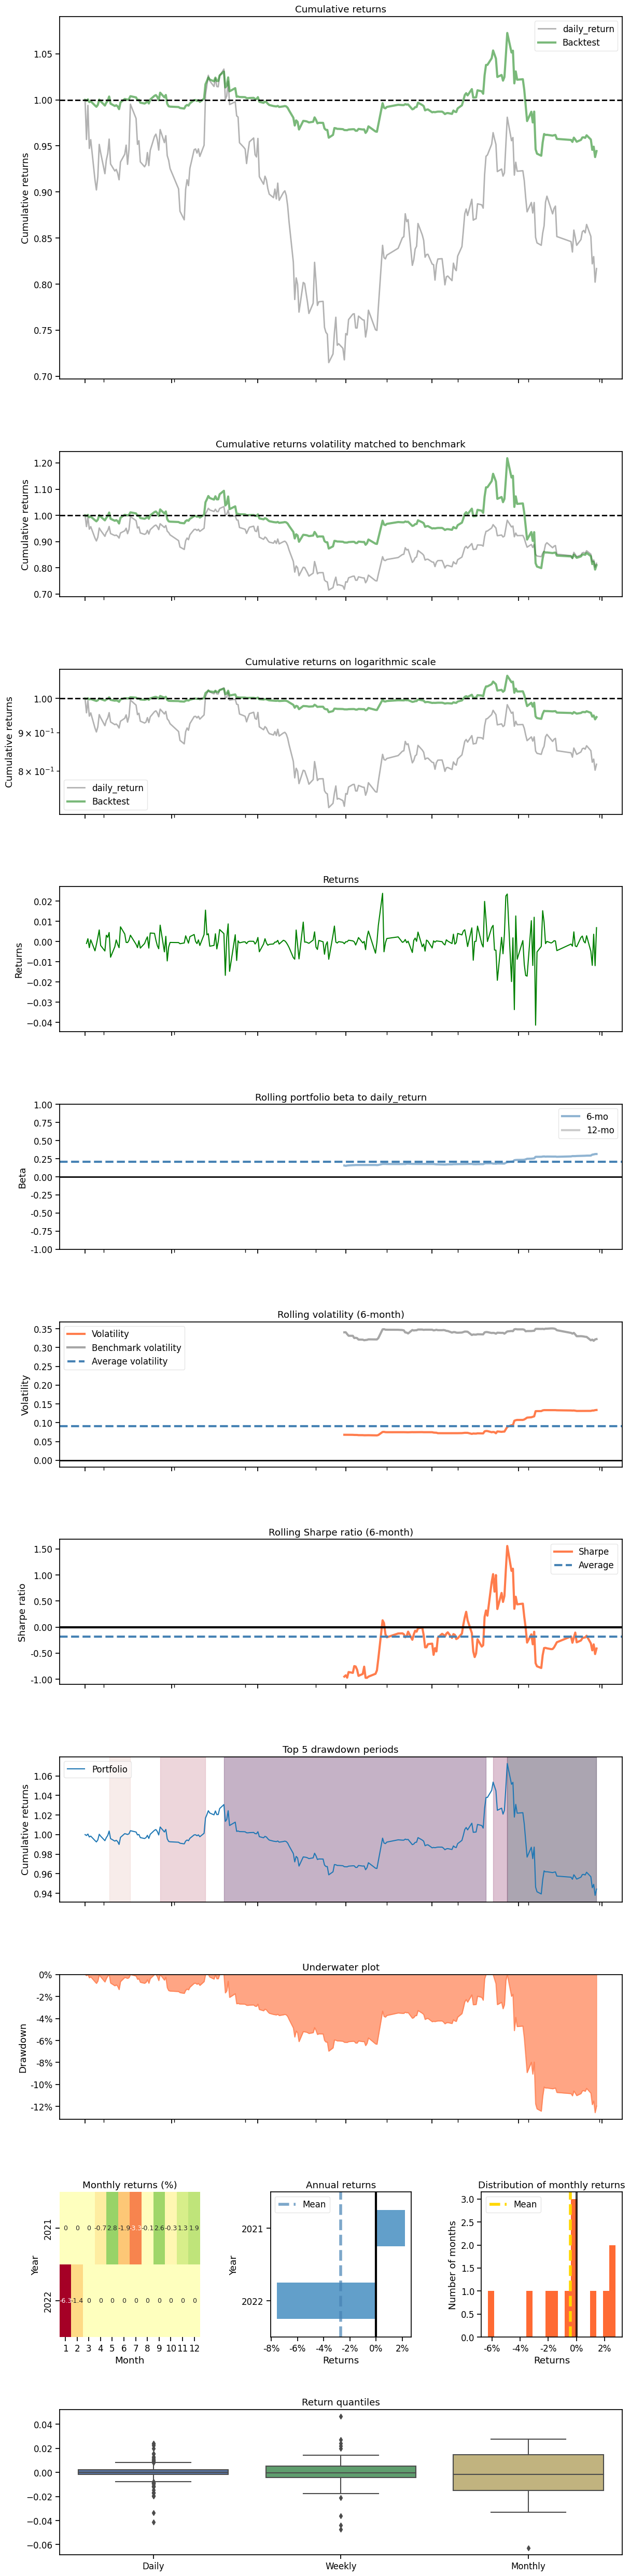

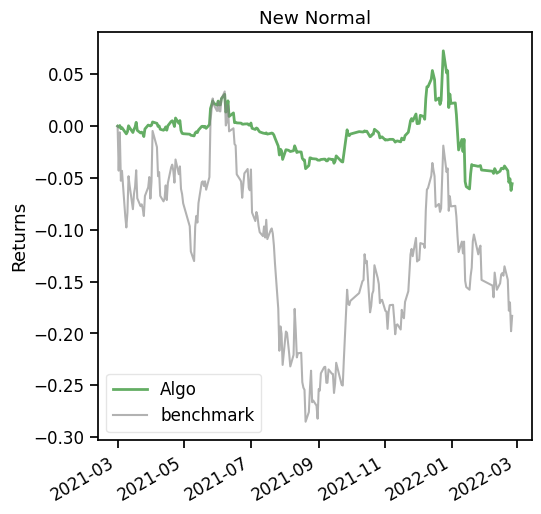

In [377]:
print("==============Compare to SSE50===========")
# from finrl.plot import backtest_plot_com
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot_com(account_value = df_account_value, 
                  baseline = baseline_sse,
                  baseline_start = df_account_value.loc[len(df_account_value)-1,'date'],
                  baseline_end = df_account_value.loc[0,'date']
                     )

In [ ]:
print(df_account_value.loc[len(df_account_value)-1,'date'],df_account_value.loc[0,'date'])